In [3]:

%load_ext autoreload
%autoreload 2

In [4]:
import os, sys
currDir = os.path.abspath('')
rootDir = os.path.abspath(os.path.join(currDir, '../../'))
print(rootDir)
if rootDir not in sys.path: # add parent dir to paths
    sys.path.append(rootDir)

/home/andylo/Projects/Text2Emoji


In [115]:
import re
import os

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

from config import PrepConfig


pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

df = pd.read_csv(PrepConfig.PROJECT_ROOT + '/data/emojis/emoji_df.csv', usecols=['emoji', 'name'])
original_len = len(df)
emoji_vocab = set(df['name'].to_list())

def clean_names(row):
    t = row['name']
    flag_re = r"flag: (.*)"
    is_flag = re.match(flag_re, t)
    if is_flag:
        # remove flag prefixes
        row['cleaned_name'] = is_flag[1]
        return row
    details_re = r"(.*): (.*)"
    is_detailed = re.match(details_re, t)
    if is_detailed:
        # remove skin tone adjective
        row['cleaned_name'] = is_detailed[1]
        return row
    row['cleaned_name'] = row['name']
    return row


df = df.apply(clean_names, axis=1)\
    .drop_duplicates(subset=['cleaned_name'], ignore_index=True)

vectorizer = TfidfVectorizer(
    # token_pattern=r"(?u)\b\w\w+\b|[!?\"\'@#$%^&*()\[\]]"
)
# print(re.match(r"(?u)\b\w\w+\b|[!?\"\'@#$%^&*()\[\]]", '#'))
tfidf_scores = vectorizer.fit_transform(df['cleaned_name']).toarray()
features_ids = np.argmax(tfidf_scores, axis=-1)
features_scores = np.max(tfidf_scores, axis=-1)
id_to_str = vectorizer.get_feature_names()

# features = [(ids, id_to_str[i], score) for i, (ids, score) in enumerate(zip(features_ids, features_scores))]
# df_features = pd.DataFrame(features, columns=['index', 'feature', 'tfidf_score'])
# df_features['index'] = pd.to_numeric(df_features['index'])
# df = df.merge(df_features, how='left', left_index=True, right_on='index')
features = [id_to_str[ids] for ids in features_ids]
df['feature'] = features
df['tfidf_score'] = features_scores
# df = df.sort_values('tfidf_score', ascending=False).drop_duplicates(['cleaned_name'])
# print(df.sample(100))
# print(len(df['name']))
# print(tfidf_scores.shape)
# print(features)
# print(np.array([id_to_str[ids] for ids in features]))
# print(vectorizer.get_feature_names())

In [ ]:
from transformers import AutoTokenizer

from config import PrepConfig

tokenizer = AutoTokenizer.from_pretrained(PrepConfig.SENTENCE_TRANSFORMER_NAME)
vocab_dict = tokenizer.get_vocab()

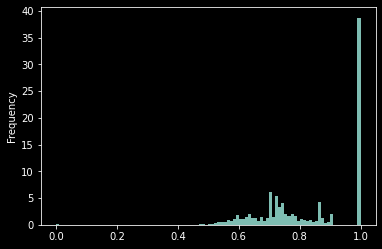

1752
1404
     emoji   feature                                  name  tfidf_score
1394     🌍    europe           globe showing Europe-Africa     0.534041
1395     👆  backhand            backhand index pointing up     0.532960
1396     📭   lowered        open mailbox with lowered flag     0.532215
1397     🈚    charge      Japanese “free of charge” button     0.531678
1398    🍽️     plate             fork and knife with plate     0.527892
1399    🇭🇰      hong             flag: Hong Kong SAR China     0.517912
1400     📬   mailbox         open mailbox with raised flag     0.511268
1401    🇮🇴    indian  flag: British Indian Ocean Territory     0.506472
1402     🈶       not  Japanese “not free of charge” button     0.484116
1403     🤣     floor         rolling on the floor laughing     0.471373


In [145]:

import matplotlib.pyplot as plt

from config import PrepConfig

plt.style.use('dark_background')

ax = df['tfidf_score'].plot.hist(bins=100, alpha=0.9, density=True)
plt.show()
print(len(df))
# print(df['tfidf_score'].value_counts())
filtered = df[df['feature'].isin(vocab_dict)]
filtered = filtered.sort_values('tfidf_score', ascending=False).drop_duplicates(['feature']).reset_index(drop=True)
print(len(filtered))
print(filtered[['emoji', 'feature', 'name', 'tfidf_score']].tail(10))

filtered.to_csv(PrepConfig.PROJECT_ROOT+'/processed_data/emoji_vocab_single.csv')

<AxesSubplot:xlabel='valid', ylabel='tfidf_score'>

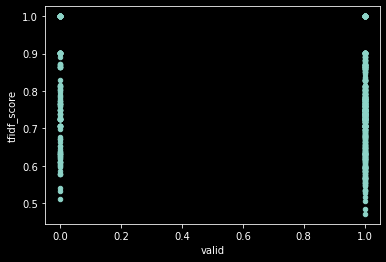

In [144]:
filtered['valid'] = filtered['feature'].isin(vocab_dict).astype(int)
filtered.plot.scatter(x='valid', y='tfidf_score')

## Test dream model

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers

from text2emoji_dream.classes.Text2EmojiDreamer import Text2EmojiDreamer
from config import DreamerConfig

tokenizer = transformers.AutoTokenizer.from_pretrained(
    DreamerConfig.SENTENCE_TRANSFORMER_NAME)
model = Text2EmojiDreamer()

ModuleNotFoundError: No module named 'text2emoji_dream'

In [158]:
text = "worried teacher"

tokenized = tokenizer(text, return_tensors='pt')
input_ids = tokenized.input_ids[0]
one_hot = torch.zeros(input_ids.size(0), tokenizer.vocab_size)
one_hot[torch.arange(input_ids.size(0)), input_ids] = 1
embeddings = model.sentence_transformer.embeddings
print(input_ids)
print(one_hot.shape)
seq_length = input_ids.size(0)
position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)  # (max_seq_length)
position_ids = position_ids  # (max_seq_length)

# word_embeddings = embeddings.word_embeddings(input_ids)  # (bs, max_seq_length, dim)
word_embeddings = one_hot.matmul(embeddings.word_embeddings.weight)
position_embeddings = embeddings.position_embeddings(position_ids)  # (bs, max_seq_length, dim)
print(f"position shape: {position_embeddings.shape}")

e = word_embeddings + position_embeddings  # (bs, max_seq_length, dim)
e = embeddings.LayerNorm(e)  # (bs, max_seq_length, dim)
e = embeddings.dropout(e)  # (bs, max_seq_length, dim)

target_embed = embeddings(input_ids.unsqueeze(0))[0]
print(e)
print(torch.all(torch.eq(e, target_embed)))
simulated_act = model.sentence_transformer(
    attention_mask = tokenized.attention_mask,
    inputs_embeds = e.unsqueeze(0)
)
semi_sim_act = model.sentence_transformer(
    attention_mask = tokenized.attention_mask,
    inputs_embeds = target_embed.unsqueeze(0)
)
target_act = model.sentence_transformer(
    attention_mask = tokenized.attention_mask,
    input_ids = input_ids.unsqueeze(0)
)
print(torch.all(torch.eq(simulated_act.last_hidden_state, semi_sim_act.last_hidden_state)))
print(torch.all(torch.eq(semi_sim_act.last_hidden_state, target_act.last_hidden_state)))
# print(semi_sim_act)
# print(target_act)
# print(embeddings.shape)
# mask = tokenized.attention_mask
# print(model.sentence_transformer.embeddings)

tensor([ 101, 5191, 3836,  102])
torch.Size([4, 30522])
position shape: torch.Size([4, 768])
tensor([[ 0.3371, -0.1221, -0.2282,  ...,  0.1648,  0.0790,  0.1264],
        [ 0.0841,  0.2840, -0.7944,  ...,  0.2766,  0.2766, -0.0253],
        [-0.1646, -0.6213,  0.1091,  ..., -0.1302, -0.2593, -0.0200],
        [-0.3929, -0.2464, -0.3519,  ..., -0.1387,  0.1298, -0.2353]])
tensor(True)
tensor(True)
tensor(True)


In [63]:
i = torch.tensor(5)
torch.sigmoid(-(torch.arange(10)-i)*2)

tensor([9.9995e-01, 9.9966e-01, 9.9753e-01, 9.8201e-01, 8.8080e-01, 5.0000e-01,
        1.1920e-01, 1.7986e-02, 2.4726e-03, 3.3535e-04])

In [65]:
input_ids = [0,5,3,4]
mask = torch.tensor([[1,1,1,0]])

onehot = model.ids_to_onehot(torch.tensor([input_ids]), vocab_size=30522)[0]
print(model.forward(onehot, mask, is_onehot=True)[0][:10])
print(model.forward(torch.tensor(input_ids), mask, is_onehot=False)[0][:10])
# tensor([-0.6654,  1.1131, -0.1976,  0.9128,  0.1838,  0.1902, -0.4161,  1.1255,
#          0.2521,  0.1622])
# tensor([-0.6654,  1.1131, -0.1976,  0.9128,  0.1838,  0.1902, -0.4161,  1.1255,
#          0.2521,  0.1622])

tensor([-0.6654,  1.1131, -0.1976,  0.9128,  0.1838,  0.1902, -0.4161,  1.1255,
         0.2521,  0.1622])
tensor([-0.6654,  1.1131, -0.1976,  0.9128,  0.1838,  0.1902, -0.4161,  1.1255,
         0.2521,  0.1622])


In [157]:
vocab_size = 6
inputs = torch.tensor([
    [0,5,3],
    # [2,4]
])
one_hot = torch.zeros((inputs.shape)+(vocab_size,))
print(one_hot.shape)
print(one_hot)
print(torch.arange(one_hot.shape[0]).unsqueeze(-1).repeat(1,2))
# one_hot[:, torch.arange(inputs.size(1)), ]
one_hot[
    torch.arange(one_hot.size(0)).unsqueeze(-1).repeat(1,one_hot.size(1)),
    torch.arange(one_hot.size(1)),
    inputs] = 1

print(one_hot)

torch.Size([1, 3, 6])
tensor([[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]])
tensor([[0, 0]])
tensor([[[1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0.]]])
